# Introduction

The following notebook will explore the taxi dataset provided by the _NYC Taxi and Limousine Commission (TLC)_. The main concerns of this notebook will be as follows:
* Explore the acessability and copyrights of the provided data
* Describe the methodology of data collection
* Check the data for structural and non-structural missingness, removing observations with missing values
    * This includes also dropping variables with large percentage of missingness
* Check the validity of entries (range is within resonable boundaries inferred from domain knowledge and common sense)
* Remove redundancy

# Data collection and copyrights

Following the [information](https://www.nyc.gov/assets/tlc/downloads/pdf/trip_record_user_guide.pdf) given by the TLC, we can clearly see that the "Yellow Taxi Cab" data from May 2015 is provided under the *Open Aceess* license. Thus, we may freely explore and manipulate the data for educational purposes.

As for data collection, we note that most of the variables were recorded automatically by the measurment apparatuses in the taxi as well as the driver themself. This information is confirmed and exracted from the following link [1](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf) [2](https://datasciencebocconi.github.io/Courses/Foundations/web/taxi_homework.html).

# Structural and non-structural missingness

## Auxiliary function and imports

Here we define some useful utility functions which will be used throughout the report.

In [70]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def preview_dataset(df):
    print(df.head())
    print(df.info())
    print(df.describe())
    print(df.columns)

def load_dataset(file):
    return pd.read_csv(file)

df = load_dataset('data/taxi_tidy_org.csv')


## Assessing missingness

### Non-structural missingness

Non-structural missingness refers to situations where missing data lacks a systematic pattern. This missingness falls into two categories:

- **Missing Completely at Random (MCAR):** The missing data is entirely random and has no relationship with other variables. Let $M_i^X$ = $1$(variable $X$ is missing for datapoint $i$). Let $W$ be a random matrix collecting all the pertinent study variables, observed or unobserved. Then $P(M_i^X = 1) = P(M_i^X = 1 | W = w)$. MCAR, in most cases, is an unrealistically strong presumption. In such cases, omission of missing data doesn't introduce structural bias in the data.
- **Missing at Random (MAR):** The pattern of missing data is related to observed variables in the dataset, but not to the specific missing value itself. Mathematically, $P(M_i^X = 1) = P(M_i^X = 1 | X_i=x_i)$ where probability is conditioned on the true, possibly unobserved, value of $X_i$.



Missing values for each column in percentage:
 Unnamed: 0           0.0
pickup_hour          0.0
pickup_month         0.0
pickup_week          0.0
pickup_doy           0.0
pickup_wday          0.0
length_time          0.0
pickup_BoroCode      0.0
pickup_NTACode       0.0
dropoff_BoroCode     0.0
dropoff_NTACode      0.0
pickup_longitude     0.0
pickup_latitude      0.0
dropoff_longitude    0.0
dropoff_latitude     0.0
vendor_id            0.0
passenger_count      0.0
trip_distance        0.0
fare_amount          0.0
pair                 0.0
dtype: float64


/Users/aliakh/Documents/GitHub/ds_taxi_homework/env/lib/python3.8/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/aliakh/Documents/GitHub/ds_taxi_homework/env/lib/python3.8/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


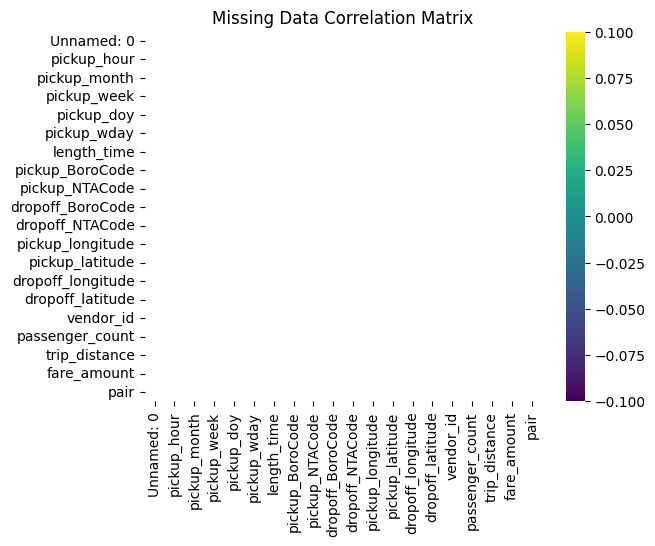

In [71]:
import pandas as pd
import missingno as msno

# Missing Data Analysis
# Checking the percentage of missing values in each column
missing_data = df.isnull().mean() * 100
print("\nMissing values for each column in percentage:\n", missing_data)

# Missing Data Correlation Analysis
# We will create a nullity matrix where missing data points are denoted with 1 and non-null data points are denoted with 0. 
# This allows us to calculate how the presence of missing data in one column is related to others.

# Create nullity matrix
nullity = df.isnull()

# Create correlation heatmap for missing data
sns.heatmap(nullity.corr(), annot=True, cmap='viridis')

plt.title('Missing Data Correlation Matrix')
plt.show()

It appears that the data is intact and there are no missing values. Therefore, there can't be any structural missingness either. 

We continue to examine whether each observation follows domain specific expectation we have for it. For example, the _pair_ column is expected to be a string equal to the concatenated result of _pickup_NTACode_ and _dropoff_NTACode_. We begin with a preview of the data.

In [72]:
print("The 'pair' column is the concatenation of the 'pickup_NTACode' and the 'dropoff_NTACode':",
 df['pair'].equals(df['pickup_NTACode'] + "-" + df['dropoff_NTACode']))

if df['pair'].equals(df['pickup_NTACode'] + "-" + df['dropoff_NTACode']):
    print("pickup_NTACode and dropoff_NTACode are redundant")
    df.drop(columns=['pickup_NTACode', 'dropoff_NTACode'], inplace=True)

print("'pickup_doy' is between May 1st and May 31st:", df['pickup_doy'].between(121, 152).all())

print("'pickup_wday' is between 1 and 7:", df['pickup_wday'].between(1, 7).all())

print("'length_time' is positive:", (df["length_time"] > 0).all())

print("'fare_amount' is positive:", (df["fare_amount"] > 0).all())

print("'trip_distance' is positive:", (df["trip_distance"] > 0).all())

The 'pair' column is the concatenation of the 'pickup_NTACode' and the 'dropoff_NTACode': True
pickup_NTACode and dropoff_NTACode are redundant
'pickup_doy' is between May 1st and May 31st: True
'pickup_wday' is between 1 and 7: True
'length_time' is positive: False
'fare_amount' is positive: True
'trip_distance' is positive: False


There are datapoints with negative or zero `length_time` and `trip_distance`. That's problematic. Let's start with `length_time`.

In [73]:
df[df.length_time <= 0]

,Unnamed: 0,pickup_hour,pickup_month,pickup_week,pickup_doy,pickup_wday,length_time,pickup_BoroCode,dropoff_BoroCode,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,vendor_id,passenger_count,trip_distance,fare_amount,pair
67425,67426,0,5,20,140,5,0,4,1,-73.781052,40.644997,-73.996933,40.761620,2,1,18.17,52.0,QN98-MN15
133170,133171,0,5,22,150,1,0,1,3,-73.999733,40.733437,-73.942871,40.677292,2,1,7.63,30.0,MN23-BK61
133282,133283,0,5,19,127,6,0,1,1,-73.994598,40.750092,-73.921638,40.866402,2,1,10.17,52.5,MN17-MN01
195373,195374,23,5,20,140,5,0,4,1,-73.781830,40.644669,-73.976044,40.744888,2,2,16.61,52.0,QN98-MN20
224232,224233,23,5,19,130,2,0,1,1,-73.962402,40.767326,-73.980606,40.739452,2,1,9.00,26.5,MN40-MN20
306685,306686,0,5,19,128,7,0,4,4,-73.937325,40.757896,-73.936760,40.764584,2,1,0.00,2.5,QN68-QN70
327737,327738,0,5,20,138,3,0,3,1,-73.990829,40.686001,-73.983177,40.744690,2,2,7.21,28.0,BK38-MN17
409413,409414,0,5,21,147,5,0,4,1,-73.871201,40.773891,-73.952881,40.824696,2,5,8.28,27.0,QN98-MN04
411312,411313,0,5,21,147,5,0,1,4,-73.987450,40.749382,-73.849152,40.723583,2,1,8.19,31.0,MN17-QN17
485878,485879,7,5,18,124,3,0,4,3,-73.788841,40.642948,-73.940361,40.715801,2,1,15.49,51.0,QN98-BK90


Looks like a few taxi drivers might be secretly testing out prototype teleportation devices. Zero `length_time` yet a positive `fare_amount` and `trip_distance`.  For the sake of data sanity, we'll have to remove these suspicious entries.

In [74]:
df = df[df.length_time > 0]

In [75]:
df[df.trip_distance == 0]

,Unnamed: 0,pickup_hour,pickup_month,pickup_week,pickup_doy,pickup_wday,length_time,pickup_BoroCode,dropoff_BoroCode,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,vendor_id,passenger_count,trip_distance,fare_amount,pair
233,234,22,5,19,127,6,146,4,4,-73.911804,40.783085,-73.911804,40.783081,1,1,0.0,38.8,QN72-QN72
1688,1689,21,5,19,129,1,3834,4,1,-73.790512,40.643993,-73.981155,40.776756,1,1,0.0,52.0,QN98-MN14
2966,2967,15,5,19,128,7,3,1,1,-73.991661,40.730068,-73.991653,40.730076,1,1,0.0,2.5,MN23-MN23
3236,3237,23,5,21,147,5,48,1,1,-73.942055,40.835396,-73.942062,40.835388,2,1,0.0,52.0,MN36-MN36
3619,3620,10,5,18,126,5,788,1,1,-73.975471,40.755363,-73.985603,40.741329,2,1,0.0,9.0,MN17-MN13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485548,485549,15,5,19,130,2,7,1,1,-74.003227,40.756222,-74.003227,40.756222,2,1,0.0,15.0,MN13-MN13
488993,488994,6,5,20,140,5,713,1,1,-73.991402,40.723930,-73.991402,40.723927,2,2,0.0,24.0,MN22-MN22
489182,489183,23,5,20,134,6,3,1,1,-73.946060,40.782200,-73.946060,40.782200,2,1,0.0,15.3,MN32-MN32
490178,490179,0,5,20,139,4,27,3,3,-73.993050,40.619965,-73.993050,40.619965,1,1,0.0,14.0,BK28-BK28


We have trips showing both zero distance and a positive fare. Unless these passengers really enjoyed a NY tour that ended exactly where they started, it seems like there might be some errors in the location data. Let's verify if the pickup and dropoff coordinates match.

In [76]:
df[(df.trip_distance == 0) & (df.pickup_latitude != df.dropoff_latitude) & (df.dropoff_longitude != df.pickup_longitude)]

,Unnamed: 0,pickup_hour,pickup_month,pickup_week,pickup_doy,pickup_wday,length_time,pickup_BoroCode,dropoff_BoroCode,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,vendor_id,passenger_count,trip_distance,fare_amount,pair
1688,1689,21,5,19,129,1,3834,4,1,-73.790512,40.643993,-73.981155,40.776756,1,1,0.0,52.0,QN98-MN14
2966,2967,15,5,19,128,7,3,1,1,-73.991661,40.730068,-73.991653,40.730076,1,1,0.0,2.5,MN23-MN23
3236,3237,23,5,21,147,5,48,1,1,-73.942055,40.835396,-73.942062,40.835388,2,1,0.0,52.0,MN36-MN36
3619,3620,10,5,18,126,5,788,1,1,-73.975471,40.755363,-73.985603,40.741329,2,1,0.0,9.0,MN17-MN13
3806,3807,17,5,20,136,1,35,1,1,-73.980057,40.783958,-73.979958,40.783901,1,1,0.0,2.5,MN12-MN12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481888,481889,12,5,21,146,4,12,1,1,-73.980721,40.764736,-73.980858,40.764778,2,2,0.0,52.0,MN17-MN17
483167,483168,6,5,19,129,1,8,1,1,-73.978523,40.780579,-73.978500,40.780655,2,1,0.0,52.0,MN12-MN12
483173,483174,2,5,20,139,4,2,1,1,-73.992729,40.768337,-73.992737,40.768349,2,1,0.0,6.0,MN15-MN15
485338,485339,13,5,20,135,7,3178,1,4,-73.999664,40.743553,-73.782936,40.648617,2,1,0.0,52.0,MN13-QN98


These values must be removed also.

In [77]:
df = df[(df.trip_distance > 0) | (df.pickup_latitude == df.dropoff_latitude) & (df.dropoff_longitude == df.pickup_longitude)]

Now, we'll verify if the distance is cogent with longitude and latitude data.

In [78]:
from math import radians, cos, sin, asin, sqrt

def haversine_miles(lon1, lat1, lon2, lat2):
    """https://en.wikipedia.org/wiki/Haversine_formula"""
    R = 3959 # Radius of Earth in miles

    dlon = radians(lon2 - lon1)
    dlat = radians(lat2 - lat1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    distance = R * c

    return distance

def check_trip_distance(df):
    """
    Checks if the calculated trip distances match the recorded values within a tolerance.
    """
    tolerance = 1 
    
    tot_deviating = 0
    for index, row in df.iterrows():
        calculated_distance = haversine_miles(row['pickup_longitude'], row['pickup_latitude'], 
                                             row['dropoff_longitude'], row['dropoff_latitude'])

        if abs(calculated_distance - row['trip_distance']) > row['trip_distance'] * tolerance:
            tot_deviating += 1
    
    return round(tot_deviating / len(df.index) * 100, 2)

print(f"{check_trip_distance(df)}% of the reported distances deviate from the calculated distance.")

0.03% of the reported distances deviate from the calculated distance.


There doesn't seem to be a significant portion of the data that deviate from the calculated distance using the Haversine formula. Note that `trip_distance` is **the elapsed distance** while the computed distance is the **straight-line distance**. Therefore, we tolerate a difference between the two values to a certain level.

## Reducing redundancy

We already dropped the `pair` column as it's redundant. Additionally, we will convert the pickup and dropoff times to a format more appropriate for modelling purposes

In [79]:
# Convert the pickup_hour: Hour of the pick-up
# pickup_month: Month of the pick-up (always May)
# pickup_week: Week of the pick-up
# pickup_doy: Day of the year of the pick-up (from 1 to 365)
# pickup_wday: Day of the week of the pick-up (from 1 to 7)
# to absolute epoch timestamps

def combine_datetime(row):
    return pd.Timestamp(year=2015, 
                        month=row['pickup_month'], 
                        day=row['pickup_doy'] - 121, 
                        hour=row['pickup_hour'])

# We apply this function to each row of the DataFrame
df['pickup_time'] = df.apply(combine_datetime, axis=1)

# We then convert the datetime from being expressed in local time to being expressed 
# as a Unix timestamp (the number of seconds since 1970-01-01 00:00:00 UTC)
df['pickup_time'] = (df['pickup_time'] - pd.Timestamp("1970-01-01 00:00:00")) // pd.Timedelta('1s')

In [80]:
df.drop(columns=['pickup_month', 'pickup_week', 'pickup_doy', 'pickup_wday', 'pickup_hour'], inplace=True)

print(df.sample(5))

        Unnamed: 0  length_time  pickup_BoroCode  dropoff_BoroCode  \
205074      205075          660                1                 1   
352646      352647         1306                1                 1   
397835      397836         1756                1                 4   
31831        31832          564                1                 1   
141577      141578         2787                1                 4   

        pickup_longitude  pickup_latitude  dropoff_longitude  \
205074        -73.979233        40.750309         -73.986397   
352646        -73.978844        40.762146         -73.976501   
397835        -73.972054        40.755882         -73.871849   
31831         -73.989243        40.753052         -73.982033   
141577        -73.996971        40.725319         -73.864136   

        dropoff_latitude  vendor_id  passenger_count  trip_distance  \
205074         40.732071          2                2           1.67   
352646         40.755562          1                2

## Graphical exploration

Now that we have assessed that no values are missing and that the variables are withing reasonable range, we will explore the dataset visuallize with box-plots and historgrams.

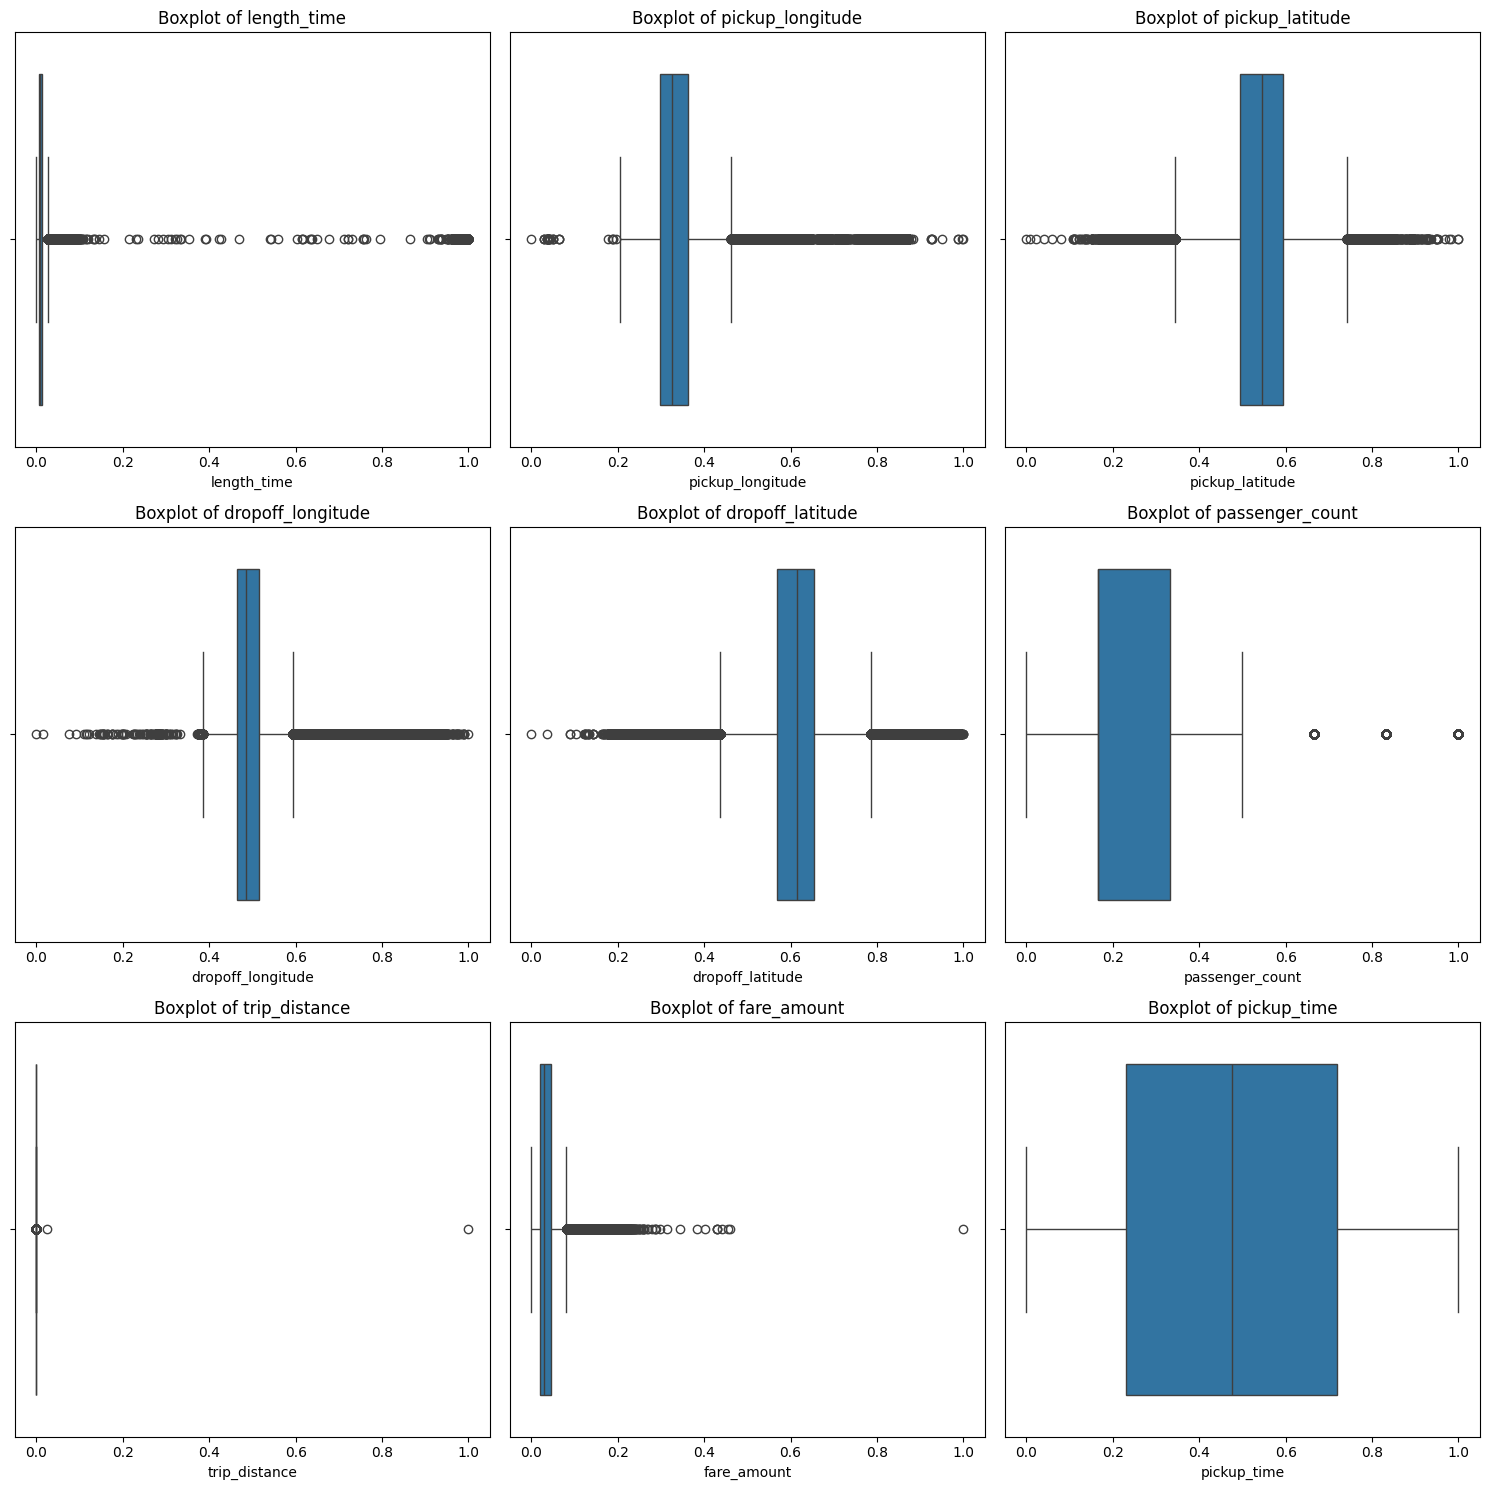

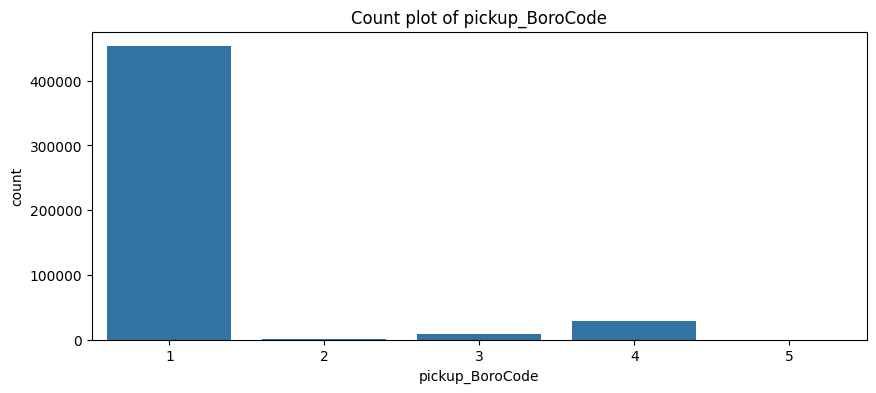

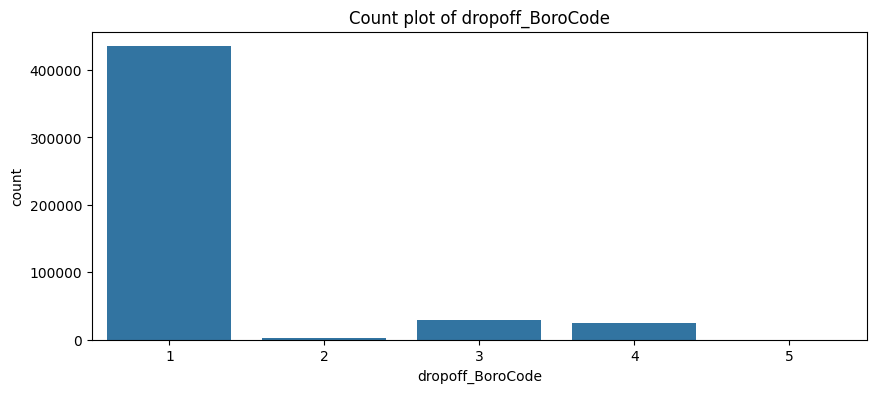

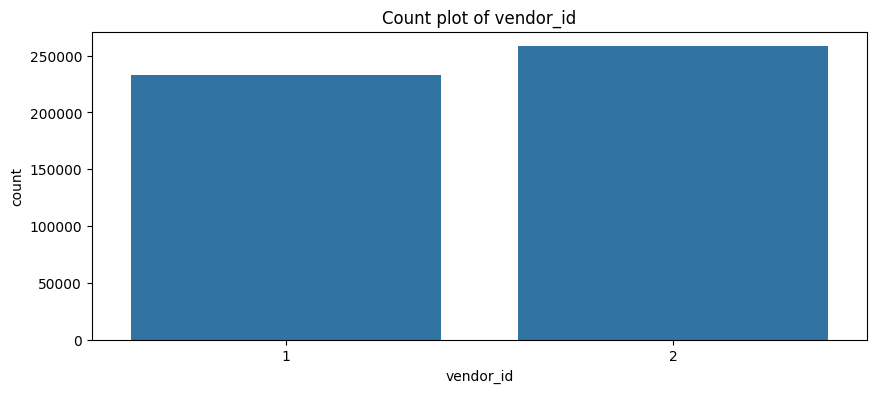

In [81]:
numerical_cols = ["length_time", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude", "passenger_count", "trip_distance", "fare_amount", "pickup_time"]
# Normalize the numerical features to get meaningful plots
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df[numerical_cols]), columns=numerical_cols)

# Define number of rows and columns for subplot grid
num_vars = len(numerical_cols)
num_cols = int(num_vars**0.5)
num_rows = num_vars // num_cols + (num_vars % num_cols > 0)

# Create subplots of boxplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for ax, col in zip(axs.flat, numerical_cols):
    sns.boxplot(x=df_normalized[col], ax=ax)
    ax.set_title(f'Boxplot of {col}')

# Delete remaining empty subplots when the number of variable is not a perfect square
for ax in axs.flat[len(numerical_cols):]:
    fig.delaxes(ax)
    
plt.tight_layout()
plt.show()


categorical_cols = ["pickup_BoroCode", "dropoff_BoroCode", 'vendor_id', "pair"]
# As for the categorical features, let's see the frequency of each category (bar plots)
for col in categorical_cols:
    if df[col].nunique() < 30:  # Only plot for columns with less unique entries
        fig, ax = plt.subplots(figsize=(10, 4))
        sns.countplot(data=df, x=col, ax=ax)
        ax.set_title(f'Count plot of {col}')
        plt.show()

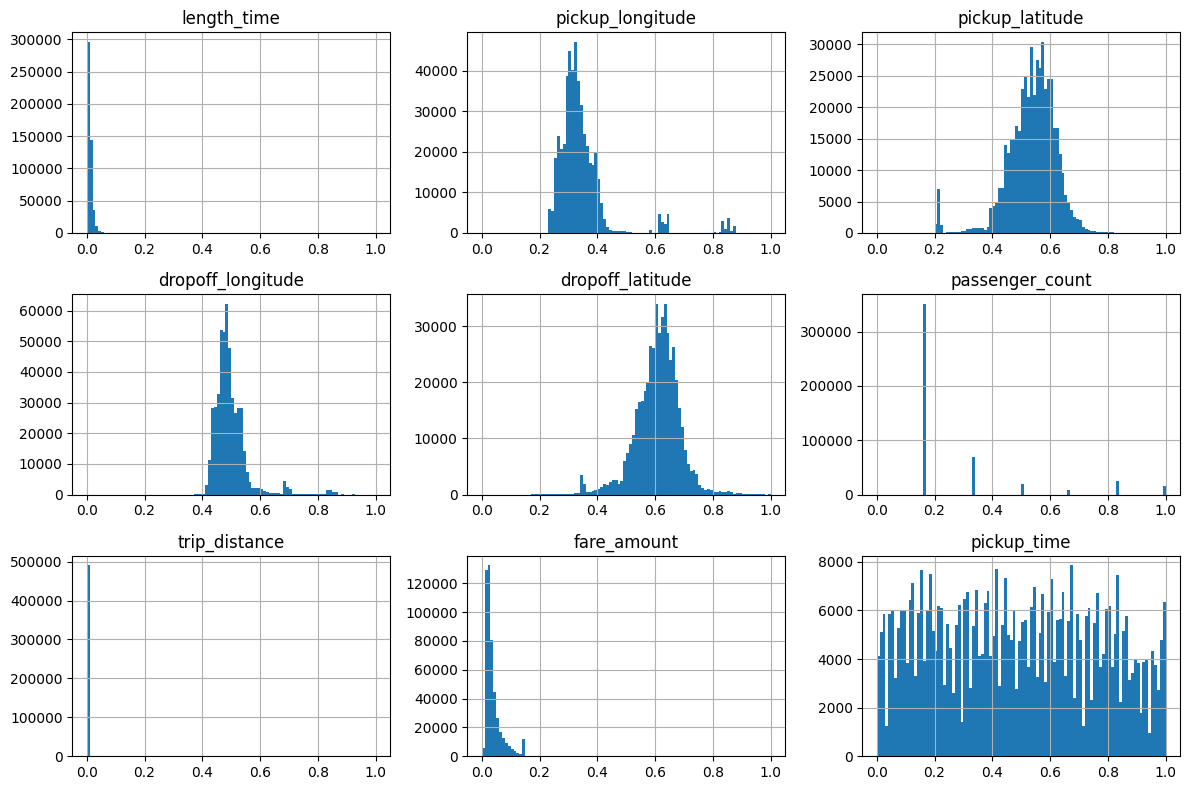

In [82]:
df_normalized.hist(figsize=(12, 8), bins=100)
plt.tight_layout()
plt.show()


Our initial analysis reveals outliers in the data and uneven representation of different areas. This geographic disparity should be considered during our statistical analysis. The distributions of `length_time`, `fare_amount`, and `trip_distance` visually resemble exponential or power law distributions.  Verifying this hypothesis is crucial, as it would imply that extreme values are inherent to the distribution and shouldn't be discarded as outliers. Traditional outlier detection methods like Z-Scores or IQR might not be suitable in this case.

## Correlation Analysis

We expect, naturally, to see correlation between some of the variables. This is not, per se, an issue. But could be problematic based on the models used in downstream analysis.

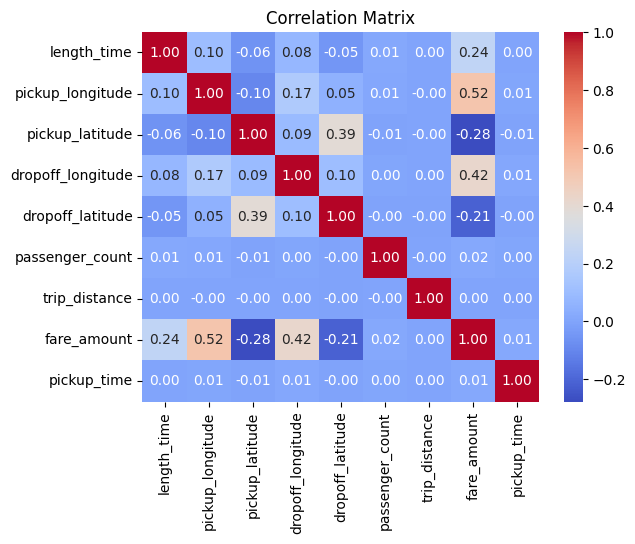

<Figure size 2400x1600 with 0 Axes>

In [83]:
corr_matrix = df_normalized[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.figure(figsize=(24, 16))  
plt.show()

Note that there are more complex, non-linear ways that the data is correlated. For example, knowing the pickup and dropoff coordinates, we can determine the Borough Code. Possibly, we could guess the vendor by knowing the pickup coordinates. We'll draw a scatterplot to check this hypothesis.

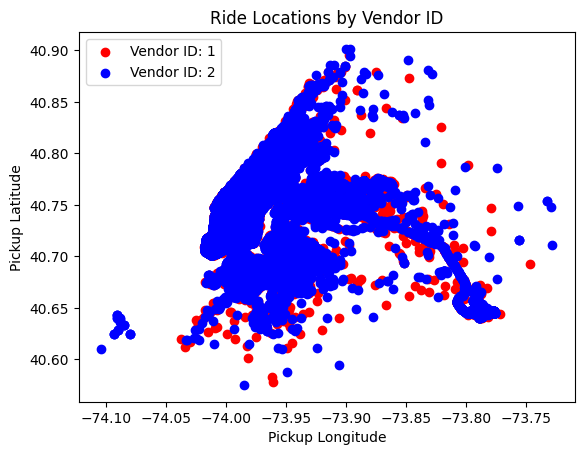

In [84]:
for vendor_id, group in df.groupby('vendor_id'):
    plt.scatter(group['pickup_longitude'], group['pickup_latitude'], 
                color='red' if vendor_id == 1 else 'blue',
                label=f"Vendor ID: {vendor_id}")

plt.xlabel("Pickup Longitude")
plt.ylabel("Pickup Latitude")
plt.title("Ride Locations by Vendor ID")
plt.legend()
plt.show()

We can see that this is not the case.

/var/folders/ts/xsr5s4hn2zs46ml6rgb5_42m0000gp/T/ipykernel_26065/1156832634.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['pickup_longitude'], df['pickup_latitude'],
/var/folders/ts/xsr5s4hn2zs46ml6rgb5_42m0000gp/T/ipykernel_26065/1156832634.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fare Amount')


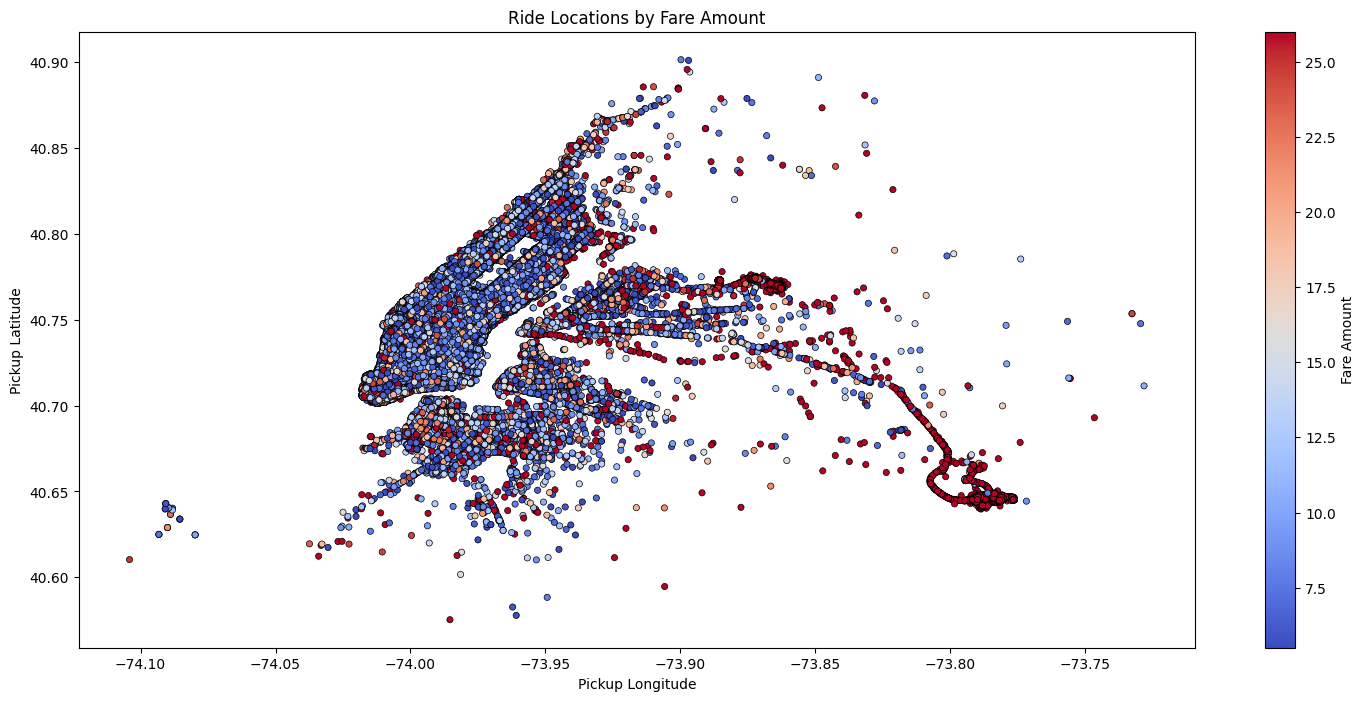

In [100]:
from matplotlib.cm import ScalarMappable

cmap = plt.cm.coolwarm
lower_percentile = df['fare_amount'].quantile(0.1)
upper_percentile = df['fare_amount'].quantile(0.9)
norm = plt.Normalize(lower_percentile, upper_percentile)
plt.figure(figsize=(18,8))
sm = ScalarMappable(cmap=cmap, norm=norm) 
sm.set_array([]) 

plt.scatter(df['pickup_longitude'], df['pickup_latitude'], 
            c=cmap(norm(df['fare_amount'])), 
            s=20, 
            cmap=cmap,
            edgecolors='black',
            linewidths=0.5)
plt.colorbar(sm, label='Fare Amount')
plt.xlabel("Pickup Longitude")
plt.ylabel("Pickup Latitude")
plt.title("Ride Locations by Fare Amount")
plt.show()

On the other hand, we can see patterns where rides from certain locations are more expensive. We compute the $r^2$.

In [102]:
import statsmodels.api as sm

X = df[['pickup_longitude', 'pickup_latitude']]
y = df['fare_amount']
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
print(model.summary())  


                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                 1.157e+05
Date:                Wed, 10 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:32:39   Log-Likelihood:            -1.7453e+06
No. Observations:              490690   AIC:                         3.491e+06
Df Residuals:                  490687   BIC:                         3.491e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.351e+04     28.465  

The large F-statistic and very small p-value indicate that the model is statistically significant and there's a correlation between pickup coordinates and the fare amount. Again, this is not necessarily problematic but must be considered during model selection.

## Conclusion

In conclusion, we'll take the original dataset, tidy it up, and store it in the data folder.

In [107]:
org_df = load_dataset('data/taxi_tidy_org.csv')

In [108]:
def combine_datetime(row):
    return pd.Timestamp(year=2015, 
                        month=row['pickup_month'], 
                        day=row['pickup_doy'] - 121, 
                        hour=row['pickup_hour'])

# We apply this function to each row of the DataFrame
org_df['pickup_time'] = org_df.apply(combine_datetime, axis=1)

# We then convert the datetime from being expressed in local time to being expressed 
# as a Unix timestamp (the number of seconds since 1970-01-01 00:00:00 UTC)
org_df['pickup_time'] = (org_df['pickup_time'] - pd.Timestamp("1970-01-01 00:00:00")) // pd.Timedelta('1s')
org_df.drop(columns=['pickup_month', 'pickup_week', 'pickup_doy', 'pickup_wday', 'pickup_hour', 'pair'], inplace=True)
org_df.head(5)

,Unnamed: 0,length_time,pickup_BoroCode,pickup_NTACode,dropoff_BoroCode,dropoff_NTACode,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,vendor_id,passenger_count,trip_distance,fare_amount,pickup_time
0,1,520,1,MN15,1,MN19,-73.983009,40.766602,-73.967972,40.760677,1,1,0.90,7.0,1431367200
1,2,672,1,MN24,1,MN17,-74.009789,40.712395,-73.983223,40.760330,1,1,3.70,12.5,1432537200
2,3,824,1,MN21,1,MN24,-73.989510,40.734470,-73.997185,40.717976,1,1,1.40,10.0,1430935200
3,4,637,1,MN17,1,MN33,-73.978989,40.755726,-73.951187,40.789021,1,1,3.40,12.0,1432692000
4,5,2491,1,MN17,4,QN98,-73.985313,40.761181,-73.865250,40.770699,2,1,11.74,37.5,1432141200


Now, we'll split the dataframe into three different dataframes:

1. Temporal Information
- pickup_time

1. Geographic Information
- pickup_BoroCode: Macro-area (borough level) of the pickup.
- pickup_NTACode: Micro-area (neighborhood level) of the pickup.
- dropoff_BoroCode: Macro-area (borough level) of the dropoff.
- dropoff_NTACode: Micro-area (neighborhood level) of the dropoff.
- pickup_longitude: Precise longitudinal coordinate of the pickup.
- pickup_latitude: Precise latitudinal coordinate of the pickup.
- dropoff_longitude: Precise longitudinal coordinate of the dropoff.
- dropoff_latitude: Precise latitudinal coordinate of the dropoff.

1. Trip-Specific Information
- length_time: Trip duration in seconds.
- vendor_id: Identifier for the taxi/ride-hailing service provider.
- passenger_count: Number of passengers.
- trip_distance: Distance traveled.
- fare_amount: Cost of the trip.

In [121]:
temporal_df = org_df[['pickup_time']]
geographic_df = org_df[['pickup_BoroCode', 'pickup_NTACode', 'dropoff_BoroCode', 'dropoff_NTACode',
                    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]
trip_df = org_df[['length_time', 'vendor_id', 'passenger_count', 'trip_distance', 'fare_amount']]

trip_df.to_csv("data/res/trip.csv")
temporal_df.to_csv("data/res/temporal.csv")
geographic_df.to_csv("data/res/geographic.csv")
org_df.drop(columns=org_df.columns[0], axis=1, inplace=True)
org_df.to_csv("data/res/tidy_dataset_bench_125kg.csv")


We can merge the data back to the original format.

In [116]:
merged_df = pd.merge(pd.merge(temporal_df, geographic_df, left_index=True, right_index=True), trip_df, left_index=True, right_index=True)
merged_df.head()


,pickup_time,pickup_BoroCode,pickup_NTACode,dropoff_BoroCode,dropoff_NTACode,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,length_time,vendor_id,passenger_count,trip_distance,fare_amount
0,1431367200,1,MN15,1,MN19,-73.983009,40.766602,-73.967972,40.760677,520,1,1,0.90,7.0
1,1432537200,1,MN24,1,MN17,-74.009789,40.712395,-73.983223,40.760330,672,1,1,3.70,12.5
2,1430935200,1,MN21,1,MN24,-73.989510,40.734470,-73.997185,40.717976,824,1,1,1.40,10.0
3,1432692000,1,MN17,1,MN33,-73.978989,40.755726,-73.951187,40.789021,637,1,1,3.40,12.0
4,1432141200,1,MN17,4,QN98,-73.985313,40.761181,-73.865250,40.770699,2491,2,1,11.74,37.5
